In [64]:
import os
def is_running_on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ and os.environ["KAGGLE_KERNEL_RUN_TYPE"] == "Interactive"
DATA_PATH = '/kaggle/input/aerial-cactus/' if is_running_on_kaggle() else 'data/'
print('Running on Kaggle' if is_running_on_kaggle() else 'Running locally')

Running locally


In [65]:
import torch
import torchvision
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import pandas as pd

In [66]:
# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [67]:
ANNOTATIONS_FILE = DATA_PATH + 'train.csv'
IMG_DIR = DATA_PATH + 'train/train/'
CHECKPOINT_DIR = '/kaggle/working/checkpoints' if is_running_on_kaggle() else 'checkpoints/'
FIGURES_DIR = '/kaggle/working/figures' if is_running_on_kaggle() else 'figures/'

SEED = 42
LEARNING_RATE = 1e-3
TRAIN_SPLIT = 0.8
EPOCHS = 100 if is_running_on_kaggle() else 100

In [68]:
torch.manual_seed(42)

In [69]:
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision.transforms.functional import equalize

class CactusDataset(Dataset):
    def __init__(self, annotations_file, img_dir):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomEqualize(p=1.0),
        ])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        processed_image = self.transform(image)
        return processed_image, label

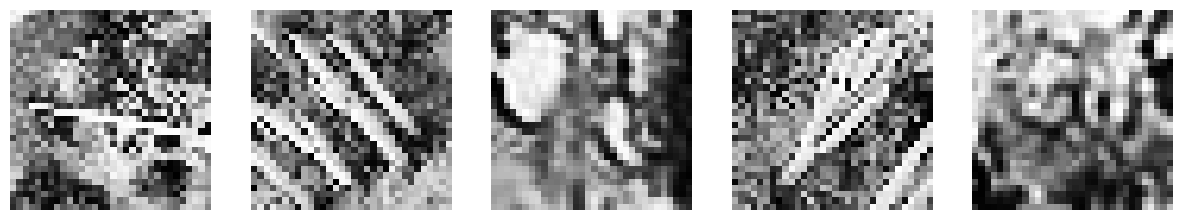

[1, 1, 0, 1, 0]


In [77]:
import random
# Create the dataset object
trainval_data = CactusDataset(ANNOTATIONS_FILE, IMG_DIR)

# Print the shape of the first image in the dataset
# print(trainval_data[0][0].shape)
# display(trainval_data[0][0])

import matplotlib.pyplot as plt
# Display the grayscale image
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
labels = []
for i, idx in enumerate([random.randint(0, len(trainval_data)) for _ in range(5)]):
    ax[i].imshow(trainval_data[idx][0].squeeze(), cmap='gray')
    labels.append(trainval_data[idx][1])
    ax[i].axis('off')
plt.show()
print(labels)

In [83]:
from torch.utils.data import random_split

# Define the sizes of training and validation sets
train_size = int(TRAIN_SPLIT * len(trainval_data))
val_size = len(trainval_data) - train_size

# Split the dataset into training and validation sets
train_data, val_data = random_split(trainval_data, [train_size, val_size])

# Print the sizes of the training and validation sets
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data))
train_tensor = next(iter(train_loader))[0]
print(train_tensor.shape)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))
val_tensor = next(iter(val_loader))[0]
print(val_tensor.shape)

Training set size: 14000
Validation set size: 3500
torch.Size([14000, 1, 32, 32])
torch.Size([3500, 1, 32, 32])


In [85]:
from sklearn.svm import SVC

# Create the model
model = SVC(kernel='rbf', C=1.0, random_state=SEED)

# Flatten the images
X_train = train_tensor.view(len(train_data), -1).numpy()
y_train = [label for _, label in train_data]

In [86]:
# Train the model
model.fit(X_train, y_train)

SVC(random_state=42)

In [87]:
# Flatten the images
X_val = val_tensor.view(len(val_data), -1).numpy()
y_val = [label for _, label in val_data]

In [88]:
# Evaluate the model
train_score = model.score(X_train, y_train)

In [90]:
val_score = model.score(X_val, y_val)

In [89]:
print(f"Train accuracy: {train_score:.2f}")

Train accuracy: 0.96


In [91]:
print(f"Validation accuracy: {val_score:.2f}")

Validation accuracy: 0.83


In [92]:
y_pred = model.predict(X_val)
accuracy = (y_pred == y_val).mean()

In [93]:
print(f"Validation accuracy: {accuracy:.2f}")

Validation accuracy: 0.83


In [98]:
X_loader = torch.utils.data.DataLoader(trainval_data, batch_size=len(trainval_data), shuffle=True)
X = next(iter(X_loader))[0]
X = X.view(len(trainval_data), -1).numpy()
y_train = [label for _, label in train_data]
y = [label for _, label in trainval_data]
print(X.shape)
print(len(y))

(17500, 1024)
17500


In [99]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, accuracy_score

Cs = [0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1]

for C in Cs:
    for gamma in gammas:
        # Create the model
        model = SVC(kernel='rbf', C=C, gamma=gamma, random_state=SEED)

        # Perform cross-validation to get predicted labels for each fold
        predicted = cross_val_predict(model, X, y, cv=5)

        # Compute the confusion matrix
        f1 = f1_score(y, predicted)
        accuracy = accuracy_score(y, predicted)

        print(f"C={C}, gamma={gamma}, F1 score: {f1:.2f}, Accuracy: {accuracy:.2f}")